In [1]:
import numpy as np
import pandas as pd
from kernel_regression import *
from scipy.optimize import fsolve
from scipy.stats import norm, kendalltau
from statsmodels.tsa.stattools import acf
import rpy2.robjects as robjects
import matplotlib.pyplot as plt
%matplotlib inline

/Users/demetri/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [15]:
class ews(object):
    
    '''
    Early Warning Signals class.  Takes in as object time series data (as numpy array or pandas series).
    Perform smoothing, obtain residuals from smoothing, apply rolling statistics.
    
    '''
    
    
    def __init__(self,x):
        
        if not isinstance(x,(np.ndarray,pd.Series)):
            raise ValueError('Data must be numpy ndarray or pandas Series')
        
        if isinstance(x,np.ndarray):
            
            if np.isnan(x).any():
                raise ValueError('Data contains nulls')
            
            if not np.issubdtype(x.dtype,np.number):
                raise ValueError('Data must be numeric')
            
            if x.ndim>1:
                raise ValueError('Data must be one dimensional')
                
            y = x
            
        if isinstance(x,pd.Series):
            
            if x.isnull().any():
                raise ValueError('Data contains nulls')
            
            if not np.issubdtype(x.dtype,np.number):
                raise ValueError('Data must be numeric')
                
            y = np.array(x)
         
        
        self.size = y.size
        self.y = y
        self.smoothed = ksmooth_py(y)
        self.residual = self.y - self.smoothed
        
    
    def detect_ews(self, stat_func, window_length = 0.5):
        
        if window_length<1 and window_length>0:
            
            window = round(window_length*self.size)
            
        elif window_length>=1:
            
            if not isinstance(window_length, int):
                raise ValueError('window_length must be integer or float between 0 and 1')
            
            window= window_length
            
        else:
            raise ValueError('window_length must be a positive float')
            
        if not hasattr(stat_func,'__call__'):
            raise ValueError('stat_func must have callable attribute')
        
        
        
        Y = pd.Series(self.residual).rolling(window).apply(stat_func)
        
        return np.array(Y)

    
    def quick_detect_ews(self,t, window_length = 0.5):
        
        if not isinstance(t,(np.ndarray,pd.Series)):
            raise ValueError('t must be numpy ndarray or pandas Series')
        
        if np.isnan(t).any():
            raise ValueError('t contains nulls')
            
            
        fig, ax = plt.subplots(nrows = 4,ncols = 1, figsize = (8,8), sharex = True)
        
        
        ax[0].plot(t,self.y, color = 'k')
        ax[0].plot(t,self.smoothed, color='r', label = 'Smoothed Data')
        ax[0].set_ylabel('Time Series')
        ax[0].legend()
        
        ax[1].plot(t,self.residual, color = 'k')
        ax[1].set_ylabel('Residual', color = 'k')
        
        std = self.detect_ews(stat_func=np.std, window_length = window_length)
        ax[2].plot(t,std, color = 'k')
        ax[2].set_ylabel('Variance')
        
        
        ac = self.detect_ews(stat_func=lambda x: acf(x)[1], window_length = window_length)
        ax[3].plot(t,ac, color = 'k')
        ax[3].set_ylabel('Lag-1 Autocorrelation')
        

        return ax
        
        


 
def quant_f(x,bw):
    
    return  norm(scale = x).ppf(0.75) - 0.25*bw

def ksmooth_py(x):
    
    t = np.arange(1,x.size+1)
    t = t.reshape(-1,1)
        
    bw = int(round(bw_nrd0(t)))
    
    sd = fsolve(quant_f ,1,bw)
    
    gamma = 0.5/sd**2
    
    kr = KernelRegression(gamma = gamma)
    
    kr.fit(t,x)
    
    ysmooth = kr.predict(t)
    
    return ysmooth
    
    
def bw_nrd0(x):

    if len(x) < 2:
        raise(Exception("need at least 2 data points"))

    hi = np.std(x, ddof=1)
    q75, q25 = np.percentile(x, [75 ,25])
    iqr = q75 - q25
    lo = min(hi, iqr/1.34)

    if not lo:
        if hi:
            lo = hi
        elif abs(x[0]):
            lo = abs(x[0])
        else:
            lo = 1

    return 0.9 * lo *len(x)**-0.2



In [16]:
df = pd.read_csv('/Users/demetri/Documents/MATLAB/data.csv',names = ['t','x'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1178238d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x117e2ca20>], dtype=object)

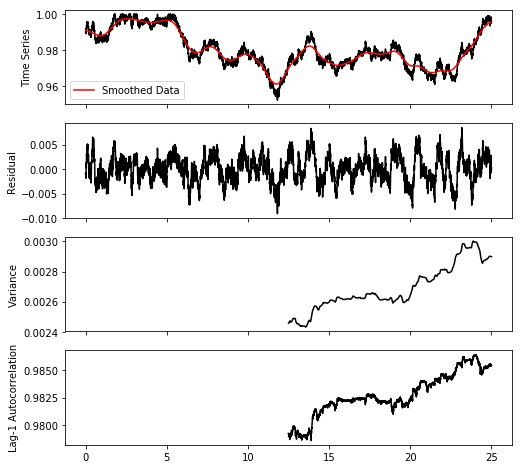

In [17]:
x = df.x.values
t = df.t.values
ews(x).quick_detect_ews(t)

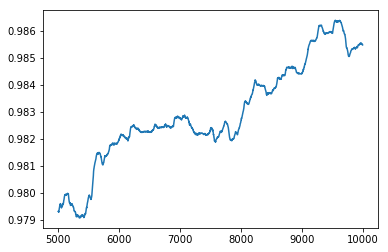

In [21]:
plt.plot(ews(x).detect_ews(stat_func = lambda x: pd.Series(x).autocorr(1)))